# Residential Heat Pump Case Study 6
Last updated: September 2023   
Erik Janssen, Research Scientist    
Sustainable Technologies Evaluation Program (STEP) of Toronto and Region Conservation Authority (TRCA)  

# Contents

- [1 Introduction](#1-Introduction): Introductory information  
<br>

- [2 Libraries](#1-Introduction): Import all needed libraries
<br>

- [3 Import Data](#1-Introduction): Import electricity and gas consumption utility data gathered from bills. Import weather data. Define a function to determine heating degree days.
<br>

- [4 Regression Analysis of Baseline Data](#4-Regression-Analysis-of-Baseline-Data): Create a baseline linear regression model of pre-retrofit gas consumption with respect to heating degree days (HDDs). Create a similar model for electricity considering HDDs and cooling degree days (CDDs). Correct baseline models as needed. Define a function which outputs the estimated baseline kWh/day and m3/day utility consumption for a given month based on the HDDs and CDDs. 
<br>

- [5 Applying Baseline Models to Post-retrofit Conditions](#5-Applying-Baseline-Models-to-Post-retrofit-Conditions): Use the baseline models to estimate the baseline energy consumption for each month of the post-retrofit data. Determine the kWh increase and m3 decrease resulting from the retrofits.
<br>

- [6 Carbon Savings](#6-Carbon-Savings): Based on the natural gas reductions and electricity increase, calculate the carbon net carbon reduction for the whole home. Since the future electricity grid emission factors are uncertain, consider different scenarios.
<br>

- [7 Cost Savings](#7-Cost-Savings): Based on the natural gas reductions and electricity increase, calculate net utility  cost reduction for the whole home. Since the future utility rates are uncertain, consider different scenarios.
<br>

#  1 Introduction

Back to [Contents](#Contents)

This notebook contains calculations accompanying the case study titled Residential "Home Heat Pump Case Study 6: Fully Electrified Home" available on smarterhomeheating.ca. The calculations are used to compare the energy consumption before and after home energy retrofits were undertaken. 

To create a fair comparison pre- and post-retrofit, the pre-retrofit data was used to create a linear regression model of home energy consumption with respect to heating (and cooling) degree days. The regression models were corrected to take into account other factors as needed, and then used to develop a baseline for energy consumption against which the actual post-retrofit energy consumption could be compared to determine the savings.

The retrofit measures considered in the analysis includes the air-sealing, basement insulation, gas stove to electric induction stove conversion, furnace-A/C replacement with air-source heat pump, and gas water heater replacement with heat pump water heater.

# 2 Libraries
Back to [Contents](#Contents)

In [39]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import datetime
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import seaborn as sns

# Reset Matplotlib's style to default
plt.style.use('default')

# Set some basic parameters for plotting and visualizing data
font = {'size'   : 14}
plt.rc('font', **font)
step_blue = "#00a3af"
step_gold = "#f8a81d"
pd.set_option('display.max_columns', None)
MonthFmt = mdates.DateFormatter('%m/%Y')

# 3 Import Data
Back to [Contents](#Contents)

In [7]:
# Import electricity data
ElecData = pd.read_csv('ElecData.csv',parse_dates = ['To','From'])
ElecData

,From,To,kWh,days,kWh_day
0,2023-02-01,2023-02-28,1457,27,53.962963
1,2023-01-01,2023-01-31,1817,30,60.566667
2,2022-12-01,2022-12-31,1705,30,56.833333
3,2022-11-01,2022-11-30,950,29,32.758621
4,2022-10-01,2022-10-31,504,30,16.800000
5,2022-09-01,2022-09-30,256,29,8.827586
6,2022-08-01,2022-08-31,226,30,7.533333
7,2022-07-01,2022-07-31,355,30,11.833333
8,2022-06-01,2022-06-30,283,29,9.758621
9,2022-05-01,2022-05-31,366,30,12.200000


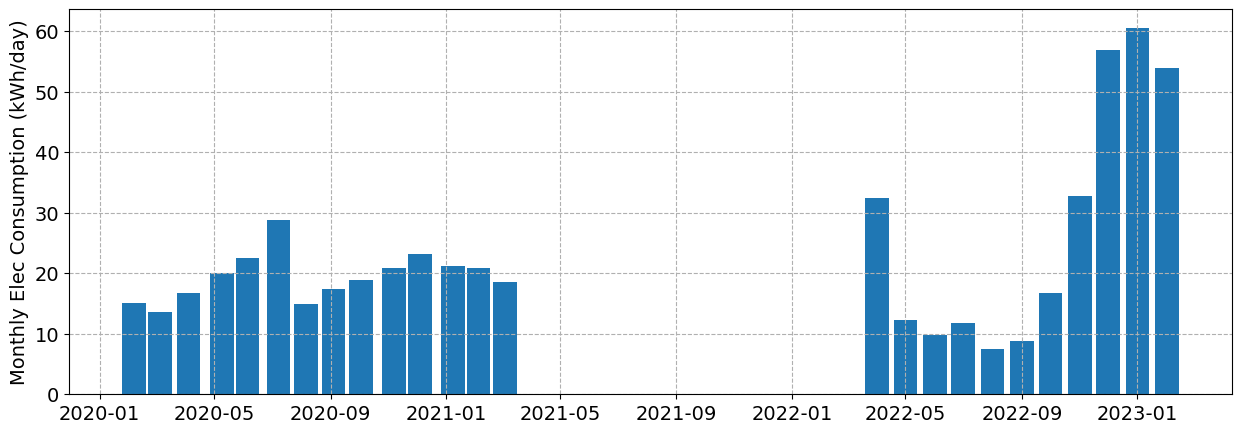

In [8]:
#Visualize electricity data
#Missing some data from mid 2021 to early 2022 - that's OK can use the post-retrofit data we have
#Only have 11-months post-retrofit 
plt.figure(figsize = (15,5))
plt.bar(ElecData.From, ElecData.kWh_day, width = 25)
plt.ylabel('Monthly Elec Consumption (kWh/day)')
plt.grid(ls='--')

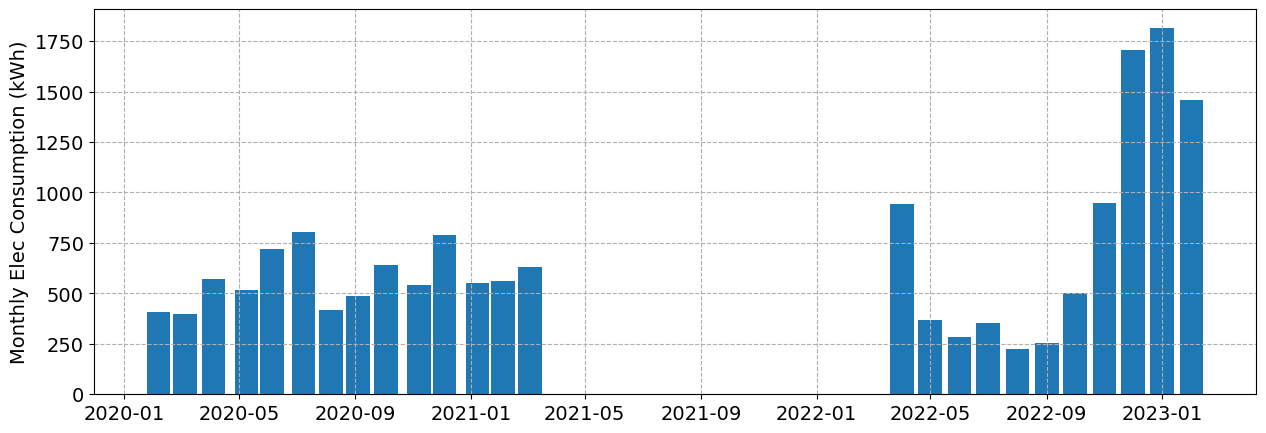

In [9]:
# Look at kWh as well (above is kWh/day)
plt.figure(figsize = (15,5))
plt.bar(ElecData.From, ElecData.kWh, width = 25)
plt.ylabel('Monthly Elec Consumption (kWh)')
plt.grid(ls='--')

In [10]:
# Import Gas data
GasData = pd.read_csv('GasData.csv',parse_dates = ['From','To'])
GasData

,From,To,m3,days,m3_day
0,2022-04-02,2022-04-28,12,26,0.461538
1,2022-03-01,2022-04-01,15,31,0.483871
2,2022-02-03,2022-02-28,13,25,0.520000
3,2021-12-31,2022-02-02,17,33,0.515152
4,2021-12-03,2021-12-30,14,27,0.518519
5,2021-10-30,2021-12-02,14,33,0.424242
6,2021-10-02,2021-10-29,9,27,0.333333
7,2021-09-03,2021-10-01,4,28,0.142857
8,2021-08-04,2021-09-02,5,29,0.172414
9,2021-07-03,2021-08-03,6,31,0.193548


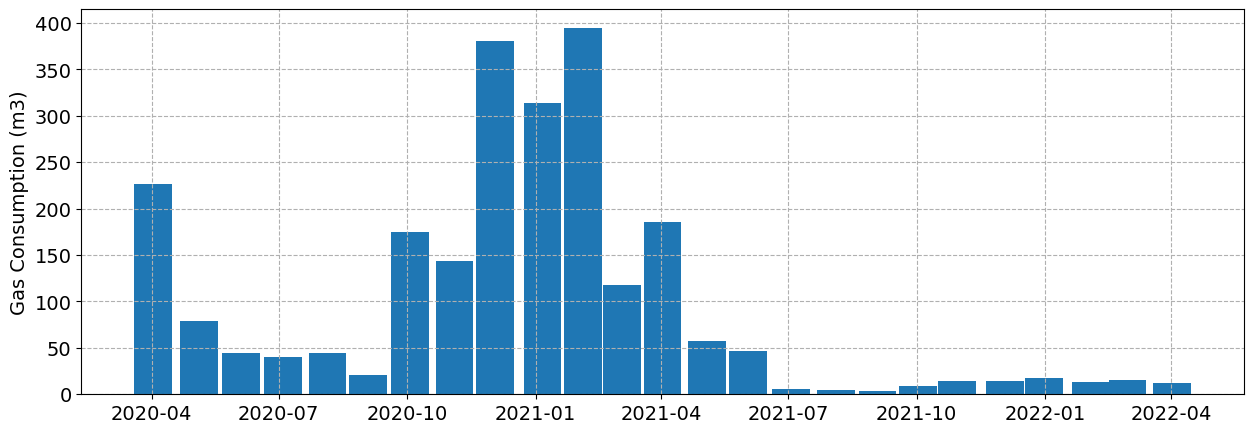

In [11]:
# Visualize gas data
# Gas was disconnected entirely after this data
# The small bit of consumption from 2021 and early 2022 is from the stove, hen gas was disconnected
plt.figure(figsize = (15,5))
plt.bar(GasData.From, GasData.m3, width = 27)
plt.ylabel('Gas Consumption (m3)')
plt.grid(ls='--')

In [12]:
# Import hourly weather data file for Toronto and calculate HDDs and CDDs
# Assumed building balance points to create the best linear relationships 
toronto_weather = pd.read_csv("weatherstats_toronto_hourly_10yr.csv",parse_dates=True, infer_datetime_format=True)
toronto_weather.date_time_local = [datetime.datetime.strptime(x,'%m/%d/%Y %H:%M') for x in toronto_weather.date_time_local]
toronto_weather = toronto_weather[['date_time_local','temperature']]
toronto_weather['HDDs'] = [(16 - x)*(1/24) if (x < 16) else 0 for x in toronto_weather.temperature] 
toronto_weather['CDDs'] = [(x-25)*(1/24) if (x > 25) else 0 for x in toronto_weather.temperature] 
toronto_weather.index = toronto_weather.date_time_local
del toronto_weather['date_time_local']
toronto_weather.head()

,temperature,HDDs,CDDs
date_time_local,,,
2023-05-10 12:00:00,18.4,0.000000,0.0
2023-05-10 11:00:00,17.2,0.000000,0.0
2023-05-10 10:00:00,16.8,0.000000,0.0
2023-05-10 09:00:00,14.3,0.070833,0.0
2023-05-10 08:00:00,11.3,0.195833,0.0


In [13]:
# Function that determines total HDDs in a given window of time
def HDD_total(start_date,end_date):
    temp_df = toronto_weather.loc[(toronto_weather.index>=start_date)&(toronto_weather.index<(end_date + datetime.timedelta(days=1)))]
    total_HDDs = temp_df.HDDs.sum()
    total_CDDs = temp_df.CDDs.sum()
    return {'HDDs':total_HDDs,
            'CDDs':total_CDDs}

# 4 Regression Analysis of Baseline Data
Back to [Contents](#Contents)
## 4.1 Gas Baseline

In [14]:
# Define a separate dataframe just for gas baseline
GasBaseline = GasData[10:].copy()
GasBaseline

,From,To,m3,days,m3_day
10,2021-06-02,2021-07-02,47,30,1.566667
11,2021-05-04,2021-06-01,57,28,2.035714
12,2021-04-02,2021-05-03,186,31,6.000000
13,2021-03-04,2021-04-01,118,28,4.214286
14,2021-02-04,2021-03-03,395,27,14.629630
15,2021-01-06,2021-02-03,314,28,11.214286
16,2020-12-03,2021-01-05,381,33,11.545455
17,2020-11-04,2020-12-02,144,28,5.142857
18,2020-10-03,2020-11-03,175,31,5.645161
19,2020-09-03,2020-10-02,21,29,0.724138


In [15]:
# Add HDDs and HDDs/day to the gas baseline dataframe
GasBaseline['HDDs'] = [HDD_total(strt,end)['HDDs'] for strt,end in zip(GasBaseline.From,GasBaseline.To)]
GasBaseline['HDDs_day'] = GasBaseline.HDDs/GasBaseline.days
GasBaseline

,From,To,m3,days,m3_day,HDDs,HDDs_day
10,2021-06-02,2021-07-02,47,30,1.566667,7.520833,0.250694
11,2021-05-04,2021-06-01,57,28,2.035714,106.466667,3.802381
12,2021-04-02,2021-05-03,186,31,6.000000,248.412500,8.013306
13,2021-03-04,2021-04-01,118,28,4.214286,355.520833,12.697173
14,2021-02-04,2021-03-03,395,27,14.629630,581.691667,21.544136
15,2021-01-06,2021-02-03,314,28,11.214286,553.854167,19.780506
16,2020-12-03,2021-01-05,381,33,11.545455,550.879167,16.693308
17,2020-11-04,2020-12-02,144,28,5.142857,275.275000,9.831250
18,2020-10-03,2020-11-03,175,31,5.645161,232.854167,7.511425
19,2020-09-03,2020-10-02,21,29,0.724138,52.795833,1.820546


coefficient of determination (R2): 0.9004232238685917
intercept: 0.7070219662882886
slope: [0.56611314]


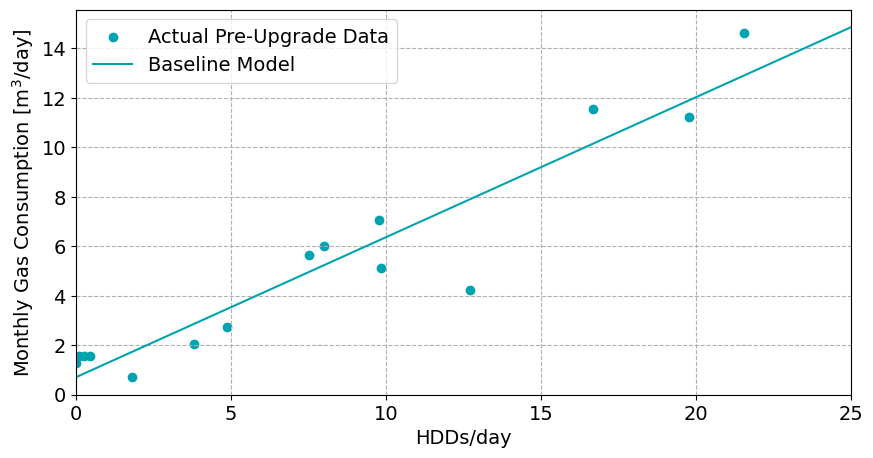

In [16]:
# Calculate regression line for baseline data
x = np.array(GasBaseline.HDDs_day).reshape((-1, 1))
y = np.array(GasBaseline.m3_day)
base_model_gas = LinearRegression()
base_model_gas.fit(x, y)
base_model_gas_r_sq = base_model_gas.score(x, y)
print('coefficient of determination (R2):', base_model_gas_r_sq)
print('intercept:', base_model_gas.intercept_)
print('slope:', base_model_gas.coef_)

# Function for baseline model
def baseline_gas(HDDs_day):
    m3_day = base_model_gas.coef_[0]*HDDs_day + base_model_gas.intercept_
    return m3_day

# Visualize pre-retrofit data, baseline model, and post-retrofit data
x = [0,25]
y = [baseline_gas(a) for a in x]
plt.figure(figsize = (10,5))
plt.scatter(GasBaseline.HDDs_day,GasBaseline.m3_day, color = step_blue, label = 'Actual Pre-Upgrade Data')
plt.plot(x,y, color = step_blue, label = 'Baseline Model')
plt.xlim(0,25)
plt.xlabel('HDDs/day')
plt.ylabel('Monthly Gas Consumption [m$^{3}$/day]')
plt.grid(ls='--')
plt.legend(loc = 2)

In [17]:
# Add the modelled baseline data to the pre-retrofit utility dataframe
GasBaseline['Modelled_m3_day'] = [baseline_gas(m3_day) for m3_day in GasBaseline.HDDs_day]
GasBaseline

,From,To,m3,days,m3_day,HDDs,HDDs_day,Modelled_m3_day
10,2021-06-02,2021-07-02,47,30,1.566667,7.520833,0.250694,0.848943
11,2021-05-04,2021-06-01,57,28,2.035714,106.466667,3.802381,2.859600
12,2021-04-02,2021-05-03,186,31,6.000000,248.412500,8.013306,5.243460
13,2021-03-04,2021-04-01,118,28,4.214286,355.520833,12.697173,7.895058
14,2021-02-04,2021-03-03,395,27,14.629630,581.691667,21.544136,12.903440
15,2021-01-06,2021-02-03,314,28,11.214286,553.854167,19.780506,11.905026
16,2020-12-03,2021-01-05,381,33,11.545455,550.879167,16.693308,10.157323
17,2020-11-04,2020-12-02,144,28,5.142857,275.275000,9.831250,6.272622
18,2020-10-03,2020-11-03,175,31,5.645161,232.854167,7.511425,4.959338
19,2020-09-03,2020-10-02,21,29,0.724138,52.795833,1.820546,1.737657


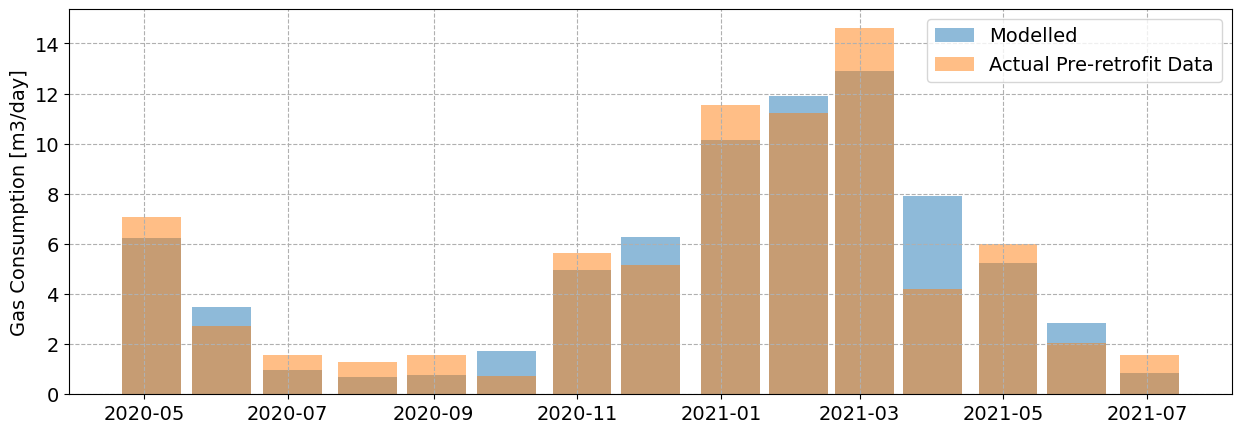

In [18]:
#Visualize model vs. actual pre-retrofit
plt.figure(figsize = (15,5))
plt.bar(GasBaseline.To,GasBaseline.Modelled_m3_day, alpha =0.5,width = 25, label = 'Modelled')
plt.bar(GasBaseline.To,GasBaseline.m3_day, alpha = 0.5, width = 25, label = 'Actual Pre-retrofit Data')
plt.grid(ls='--')
plt.ylabel('Gas Consumption [m3/day]')
plt.legend()


## 4.2 Electricity Baseline

In [19]:
# Define an electricity baseline dataframe
ElecBaseline = ElecData[11:23].copy()
ElecBaseline

,From,To,kWh,days,kWh_day
11,2021-03-04,2021-04-07,630,34,18.529412
12,2021-02-04,2021-03-03,563,27,20.851852
13,2021-01-08,2021-02-03,552,26,21.230769
14,2020-12-04,2021-01-07,788,34,23.176471
15,2020-11-07,2020-12-03,543,26,20.884615
16,2020-10-03,2020-11-06,642,34,18.882353
17,2020-09-04,2020-10-02,485,28,17.321429
18,2020-08-06,2020-09-03,418,28,14.928571
19,2020-07-08,2020-08-05,804,28,28.714286
20,2020-06-05,2020-07-07,720,32,22.500000


In [20]:
# Add HDDs, CDDs, HDDs/day and CDDs/day
ElecBaseline['HDDs'] = [HDD_total(strt,end)['HDDs'] for strt,end in zip(ElecBaseline.From,ElecBaseline.To)]
ElecBaseline['CDDs'] = [HDD_total(strt,end)['CDDs'] for strt,end in zip(ElecBaseline.From,ElecBaseline.To)]
ElecBaseline['HDDs_day'] = ElecBaseline.HDDs/ElecBaseline.days
ElecBaseline['CDDs_day'] = ElecBaseline.CDDs/ElecBaseline.days
ElecBaseline

,From,To,kWh,days,kWh_day,HDDs,CDDs,HDDs_day,CDDs_day
11,2021-03-04,2021-04-07,630,34,18.529412,413.225000,0.000000,12.153676,0.000000
12,2021-02-04,2021-03-03,563,27,20.851852,581.691667,0.000000,21.544136,0.000000
13,2021-01-08,2021-02-03,552,26,21.230769,519.750000,0.000000,19.990385,0.000000
14,2020-12-04,2021-01-07,788,34,23.176471,570.845833,0.000000,16.789583,0.000000
15,2020-11-07,2020-12-03,543,26,20.884615,280.362500,0.000000,10.783173,0.000000
16,2020-10-03,2020-11-06,642,34,18.882353,241.904167,0.000000,7.114828,0.000000
17,2020-09-04,2020-10-02,485,28,17.321429,52.737500,0.608333,1.883482,0.021726
18,2020-08-06,2020-09-03,418,28,14.928571,2.308333,19.916667,0.082440,0.711310
19,2020-07-08,2020-08-05,804,28,28.714286,0.108333,32.395833,0.003869,1.156994
20,2020-06-05,2020-07-07,720,32,22.500000,13.116667,35.750000,0.409896,1.117188


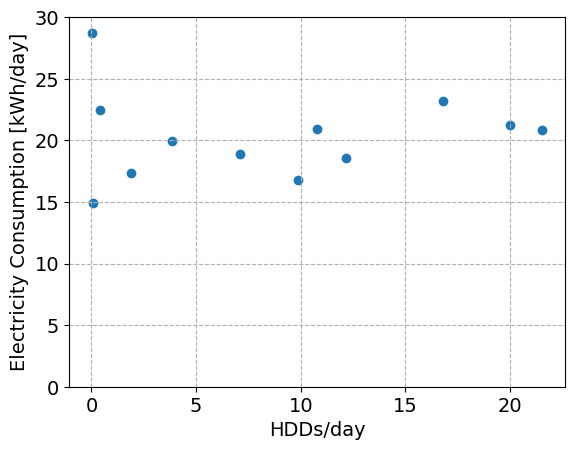

In [21]:
#Visualize variation in kWh/day
plt.scatter(ElecBaseline.HDDs_day,ElecBaseline.kWh_day)
plt.ylim(0,30)
plt.ylabel('Electricity Consumption [kWh/day]')
plt.xlabel('HDDs/day')
plt.grid(ls = '--')

coefficient of determination (R2): 0.33582013598343396
intercept: 15.471833221146218
slope: [7.56689825]


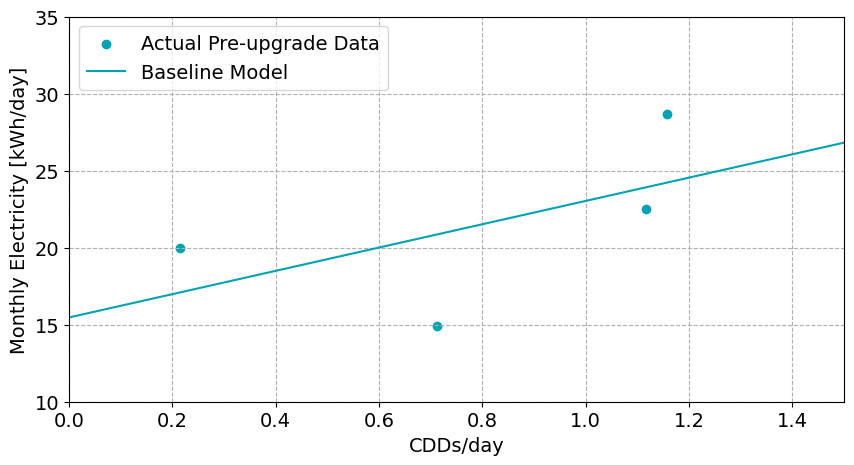

In [22]:
# Clear that I need to considers CDDs and HDDs separately for elec consumption
# Find correlations with CDDs
# Cooling df
ElecBaselineCool = ElecBaseline.loc[ElecBaseline.CDDs > 1]

# Calculate regression line for baseline data
x = np.array(ElecBaselineCool.CDDs_day).reshape((-1, 1))
y = np.array(ElecBaselineCool.kWh_day)
base_model_ElecCool = LinearRegression()
base_model_ElecCool.fit(x, y)
base_model_ElecCool_r_sq = base_model_ElecCool.score(x, y)
print('coefficient of determination (R2):', base_model_ElecCool_r_sq)
print('intercept:', base_model_ElecCool.intercept_)
print('slope:', base_model_ElecCool.coef_)

# Function for baseline model
def baseline_ElecCool(CDDs_day):
    kWh_day = base_model_ElecCool.coef_[0]*CDDs_day + base_model_ElecCool.intercept_
    return kWh_day


# Visualize pre-retrofit data, baseline model, and post-retrofit data
x = [0,5]
y = [baseline_ElecCool(a) for a in x]
plt.figure(figsize = (10,5))
plt.scatter(ElecBaselineCool.CDDs_day,ElecBaselineCool.kWh_day, color = step_blue, label = 'Actual Pre-upgrade Data')
plt.plot(x,y, color = step_blue, label = 'Baseline Model')
plt.xlim(0,1.5)
plt.ylim(10,35)
plt.xlabel('CDDs/day')
plt.ylabel('Monthly Electricity [kWh/day]')
plt.grid(ls='--')
plt.legend(loc = 2)

coefficient of determination (R2): 0.5115668654829766
intercept: 16.76462580617682
slope: [0.23520443]


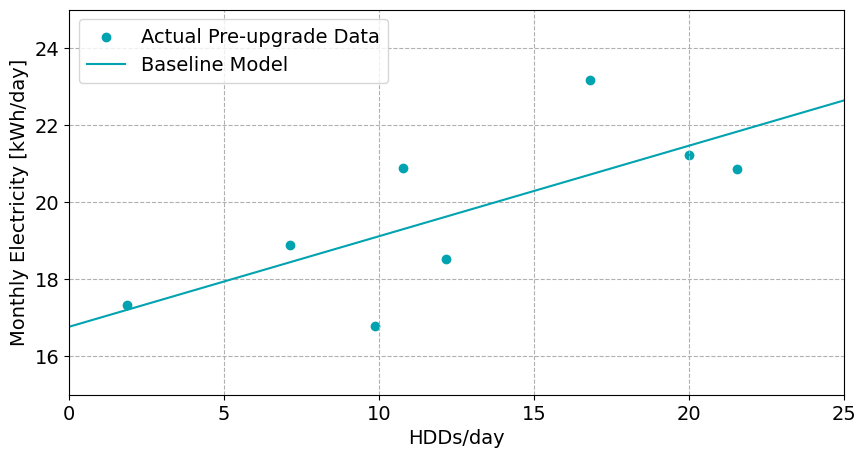

In [23]:
# Find correlations with HDDs
# Heat df
ElecBaselineHeat = ElecBaseline.loc[ElecBaseline.CDDs <= 1]

# Calculate regression line for baseline data
x = np.array(ElecBaselineHeat.HDDs_day).reshape((-1, 1))
y = np.array(ElecBaselineHeat.kWh_day)
base_model_ElecHeat = LinearRegression()
base_model_ElecHeat.fit(x, y)
base_model_ElecHeat_r_sq = base_model_ElecHeat.score(x, y)
print('coefficient of determination (R2):', base_model_ElecHeat_r_sq)
print('intercept:', base_model_ElecHeat.intercept_)
print('slope:', base_model_ElecHeat.coef_)

# Function for baseline model
def baseline_ElecHeat(HDDs_day):
    kWh_day = base_model_ElecHeat.coef_[0]*HDDs_day + base_model_ElecHeat.intercept_
    return kWh_day

# Visualize pre-retrofit data, baseline model, and post-retrofit data
x = [0,800]
y = [baseline_ElecHeat(a) for a in x]
plt.figure(figsize = (10,5))
plt.scatter(ElecBaselineHeat.HDDs_day,ElecBaselineHeat.kWh_day, color = step_blue, label = 'Actual Pre-upgrade Data')
plt.plot(x,y, color = step_blue, label = 'Baseline Model')
plt.xlim(0,25)
plt.ylim(15,25)
plt.xlabel('HDDs/day')
plt.ylabel('Monthly Electricity [kWh/day]')
plt.grid(ls='--')
plt.legend(loc = 2)


There is a slight dependence of electricity consumption on CDDs and HDDs. When asked about potential differences in energy consumption the homeowner noted that they used to have a hydroponic vegetable system: 

"It’s a bit of a DIY system - lights, pump, etc. And it’s tough to calculate how much it’s in use.  I think the last time I figured it out, it was measured in a few kw/h per day. I think it’s 9 20w led lights that were on roughly 18hours a day. I’m not sure what the pump uses, but it’s not on often (18 minutes today a day). There are also two small fans (i think 20w each) that are on always. It was first turned on in April 2020 I think I shut it off completely in June 2021." 

In [24]:
# Define an adjustement term based on the information about the hydroponic system
adjustment = 9*20*18/1000 + (20*2*24)/1000 # kWh/day
adjustment

4.2

In [25]:
# Define a function to determine baseline electricity, considering HDDs_day and CDDs_day.
def baseline_Elec(HDDs_day,CDDs_day,CDDs):
    kWh_day = 'ERROR'
    if CDDs >= 1:
        kWh_day = base_model_ElecCool.coef_[0]*CDDs_day + base_model_ElecCool.intercept_ - adjustment
    else:
        kWh_day = base_model_ElecHeat.coef_[0]*HDDs_day + base_model_ElecHeat.intercept_ - adjustment
    return kWh_day

# 5 Applying Baseline Models to Post-retrofit Conditions
Back to [Contents](#Contents)

In [26]:
# Define a post-retrofit electricity dataframe
post_elec = ElecData[0:11].copy()
post_elec

,From,To,kWh,days,kWh_day
0,2023-02-01,2023-02-28,1457,27,53.962963
1,2023-01-01,2023-01-31,1817,30,60.566667
2,2022-12-01,2022-12-31,1705,30,56.833333
3,2022-11-01,2022-11-30,950,29,32.758621
4,2022-10-01,2022-10-31,504,30,16.800000
5,2022-09-01,2022-09-30,256,29,8.827586
6,2022-08-01,2022-08-31,226,30,7.533333
7,2022-07-01,2022-07-31,355,30,11.833333
8,2022-06-01,2022-06-30,283,29,9.758621
9,2022-05-01,2022-05-31,366,30,12.200000


In [27]:
# Add CDD and HDD parameters
post_elec['HDDs'] = [HDD_total(strt,end)['HDDs'] for strt,end in zip(post_elec.From,post_elec.To)]
post_elec['HDDs_day'] = post_elec.HDDs/post_elec.days
post_elec['CDDs'] = [HDD_total(strt,end)['CDDs'] for strt,end in zip(post_elec.From,post_elec.To)]
post_elec['CDDs_day'] = post_elec.CDDs/post_elec.days
post_elec

,From,To,kWh,days,kWh_day,HDDs,HDDs_day,CDDs,CDDs_day
0,2023-02-01,2023-02-28,1457,27,53.962963,489.075000,18.113889,0.000000,0.000000
1,2023-01-01,2023-01-31,1817,30,60.566667,517.183333,17.239444,0.000000,0.000000
2,2022-12-01,2022-12-31,1705,30,56.833333,503.970833,16.799028,0.000000,0.000000
3,2022-11-01,2022-11-30,950,29,32.758621,326.933333,11.273563,0.000000,0.000000
4,2022-10-01,2022-10-31,504,30,16.800000,179.791667,5.993056,0.000000,0.000000
5,2022-09-01,2022-09-30,256,29,8.827586,35.591667,1.227299,3.229167,0.111351
6,2022-08-01,2022-08-31,226,30,7.533333,1.183333,0.039444,18.166667,0.605556
7,2022-07-01,2022-07-31,355,30,11.833333,1.325000,0.044167,25.591667,0.853056
8,2022-06-01,2022-06-30,283,29,9.758621,16.991667,0.585920,14.150000,0.487931
9,2022-05-01,2022-05-31,366,30,12.200000,74.758333,2.491944,6.520833,0.217361


In [28]:
# Apply the models to determines baseline kWh
post_elec['baseline_kWh_day'] = [baseline_Elec(x,y,z) for x,y,z in zip(post_elec.HDDs_day,post_elec.CDDs_day,post_elec.CDDs)]
post_elec['baseline_kWh'] = post_elec.days * post_elec.baseline_kWh_day
post_elec['change_kWh'] = post_elec.kWh - post_elec.baseline_kWh 
post_elec

,From,To,kWh,days,kWh_day,HDDs,HDDs_day,CDDs,CDDs_day,baseline_kWh_day,baseline_kWh,change_kWh
0,2023-02-01,2023-02-28,1457,27,53.962963,489.075000,18.113889,0.000000,0.000000,16.825093,454.277504,1002.722496
1,2023-01-01,2023-01-31,1817,30,60.566667,517.183333,17.239444,0.000000,0.000000,16.619420,498.582586,1318.417414
2,2022-12-01,2022-12-31,1705,30,56.833333,503.970833,16.799028,0.000000,0.000000,16.515832,495.474948,1209.525052
3,2022-11-01,2022-11-30,950,29,32.758621,326.933333,11.273563,0.000000,0.000000,15.216218,441.270317,508.729683
4,2022-10-01,2022-10-31,504,30,16.800000,179.791667,5.993056,0.000000,0.000000,13.974219,419.226571,84.773429
5,2022-09-01,2022-09-30,256,29,8.827586,35.591667,1.227299,3.229167,0.111351,12.114412,351.317939,-95.317939
6,2022-08-01,2022-08-31,226,30,7.533333,1.183333,0.039444,18.166667,0.605556,15.854010,475.620315,-249.620315
7,2022-07-01,2022-07-31,355,30,11.833333,1.325000,0.044167,25.591667,0.853056,17.726818,531.804534,-176.804534
8,2022-06-01,2022-06-30,283,29,9.758621,16.991667,0.585920,14.150000,0.487931,14.963958,433.954774,-150.954774
9,2022-05-01,2022-05-31,366,30,12.200000,74.758333,2.491944,6.520833,0.217361,12.916583,387.497479,-21.497479


In [29]:
# Since they got off gas entirely, just apply the gas baseline models to the HDDs in the electricity dataframe
post_elec['baseline_m3_day'] = [baseline_gas(x) for x in post_elec.HDDs_day]
post_elec['baseline_m3'] = post_elec.baseline_m3_day * post_elec.days
post_elec['Act_m3'] = [0 for _ in post_elec.index]


In [30]:
# Total gas reduction
gas_savings = post_elec.baseline_m3.sum()
gas_savings

1604.4806317826185

In [31]:
# Total electricity increase
elec_increase = post_elec.change_kWh.sum()
elec_increase

3939.799844905896

In [32]:
# Total electricity consumption
elec_tot = post_elec.kWh.sum()
elec_tot

8860

In [33]:
post_elec.baseline_kWh.sum()

4920.200155094104

(array([19113., 19144., 19174., 19205., 19236., 19266., 19297., 19327.,
        19358., 19389., 19417.]),
 [Text(19113.0, 0, '2022-05'),
  Text(19144.0, 0, '2022-06'),
  Text(19174.0, 0, '2022-07'),
  Text(19205.0, 0, '2022-08'),
  Text(19236.0, 0, '2022-09'),
  Text(19266.0, 0, '2022-10'),
  Text(19297.0, 0, '2022-11'),
  Text(19327.0, 0, '2022-12'),
  Text(19358.0, 0, '2023-01'),
  Text(19389.0, 0, '2023-02'),
  Text(19417.0, 0, '2023-03')])

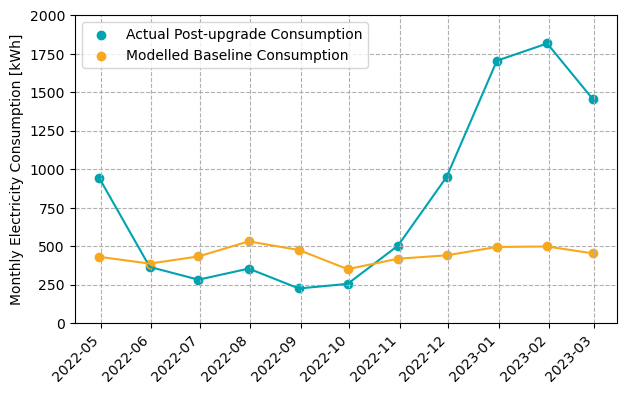

In [34]:
# Visualize elec change
plt.style.use('default')
plt.figure(figsize = (7,4))
plt.plot(post_elec.To,post_elec.kWh, color = step_blue)
plt.scatter(post_elec.To,post_elec.kWh, color = step_blue, label = 'Actual Post-upgrade Consumption')
plt.scatter(post_elec.To,post_elec.baseline_kWh, color = step_gold,label = 'Modelled Baseline Consumption',)
plt.plot(post_elec.To,post_elec.baseline_kWh, color = step_gold, )
plt.grid(ls='--')
plt.ylim(0,2000)
plt.legend()
plt.ylabel('Monthly Electricity Consumption [kWh]')
plt.xticks(rotation=45, ha = 'right')  # Adjust the angle as needed


(array([19113., 19144., 19174., 19205., 19236., 19266., 19297., 19327.,
        19358., 19389., 19417.]),
 [Text(19113.0, 0, '2022-05'),
  Text(19144.0, 0, '2022-06'),
  Text(19174.0, 0, '2022-07'),
  Text(19205.0, 0, '2022-08'),
  Text(19236.0, 0, '2022-09'),
  Text(19266.0, 0, '2022-10'),
  Text(19297.0, 0, '2022-11'),
  Text(19327.0, 0, '2022-12'),
  Text(19358.0, 0, '2023-01'),
  Text(19389.0, 0, '2023-02'),
  Text(19417.0, 0, '2023-03')])

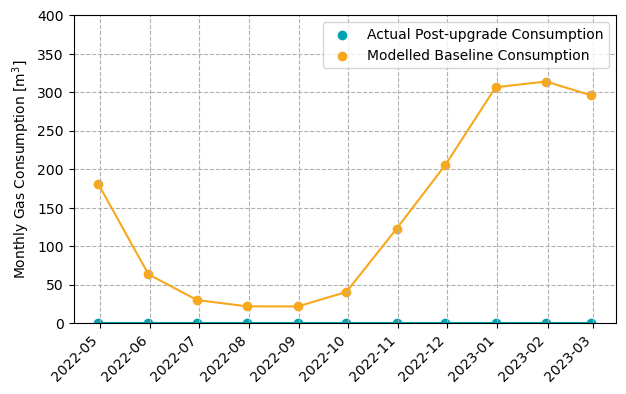

In [35]:
# Visualize gas change
plt.style.use('default')
plt.figure(figsize = (7,4))
plt.plot(post_elec.To,post_elec.Act_m3, color = step_blue)
plt.scatter(post_elec.To,post_elec.Act_m3, color = step_blue, label = 'Actual Post-upgrade Consumption',)
plt.plot(post_elec.To,post_elec.baseline_m3,  color = step_gold)
plt.scatter(post_elec.To,post_elec.baseline_m3, color = step_gold, label = 'Modelled Baseline Consumption')
plt.grid(ls='--')
plt.ylim(0,400)
plt.legend()
plt.ylabel('Monthly Gas Consumption [m$^{3}$]')
plt.xticks(rotation=45, ha = 'right')  # Adjust the angle as needed

# 6 Carbon Savings
Back to [Contents](#Contents)

In [36]:
# Gas EF
gas_EF = 1998 # g/m3

# Net carbon savings
carb_savings_AEF = post_elec.baseline_m3.sum()*gas_EF/1e6 - elec_increase*70/1e6 
carb_savings_AEF


2.9299663131582587

In [37]:
# Net carbon savings
carb_savings_AEF = post_elec.baseline_m3.sum()*gas_EF/1e6 - elec_increase*251/1e6 
carb_savings_AEF

2.2168625412302916

# 7 Cost Savings
Back to [Contents](#Contents)

Text(92.25, 0.5, 'Average Electricity Rate [$/kWh]')

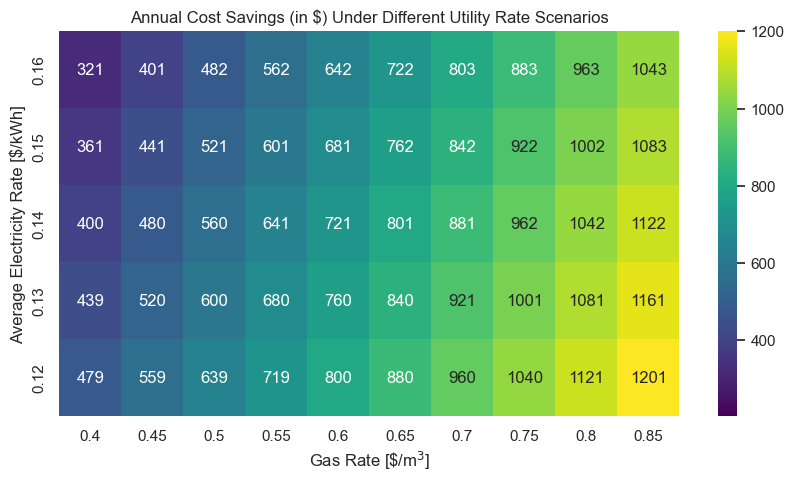

In [51]:
# Consider marginal Electricity Rate 0.12 to 0.17
elec_rates = np.arange(0.12,0.17,0.01)

# Consider marginal gas rates from 0.40 to 0.90
gas_rates = np.arange(0.40,0.90,0.05)

# Function to calc savings
def savings(gas_rate,elec_rate):
    savings = gas_savings * gas_rate - elec_increase*elec_rate + 12*25.85
    return round(savings,1)

# Run through different scenarios of gas and elec rates, and put results in a df
dic = {}

for gas_rate in gas_rates:
    col = []
    for elec_rate in elec_rates:
        col.append(int(savings(gas_rate,elec_rate)))
    dic[round(gas_rate,2)] = col
    
df = pd.DataFrame(dic)
df.index = [round(x,3) for x in elec_rates]
df = df.reindex([0.16,0.15,0.14,0.13,0.12])

# Plot a heat map showing the results
sns.set(rc={'figure.figsize':(10,5)})
sns.heatmap(df, cmap = 'viridis', annot = True, vmin = 203,vmax=1200, fmt = 'n')
plt.title('Annual Cost Savings (in $) Under Different Utility Rate Scenarios')
plt.xlabel('Gas Rate [\$/m$^{3}$]')
plt.ylabel('Average Electricity Rate [$/kWh]')    
    

Define the historical gas rates

In [52]:
# Gas rate April 2022 1st to Jul 1st 2022 - https://www.oeb.ca/sites/default/files/qram-egi-20220401.pdf
# Gas rate Jul 1st 2022 to Oct 1st 2022 - https://www.oeb.ca/sites/default/files/qram-egi-20220701-en.pdf
# Gas rate Oct 1st 2022 to Jan 1st 2023 - https://www.oeb.ca/sites/default/files/qram-egi-20221001-en.pdf
# Gas rate Jan 1st 2023 to April 1st 2023 -https://www.oeb.ca/sites/default/files/qram-egi-20230101-en.pdf
# Uncomment 22.60*1.13 in each cell below to do the sensitivity w.r.t. remaining carbon charge

gas_apr2022 = 1.13*(18.3745 - 0.3623 + (11.299 + 10.6591 + 10.1573 + 9.7832)/4 + 0.0070 + 3.9258 + 9.79 + 0.0298 - 0.2204) # 22.61*1.13
gas_apr2022

47.4815265

In [53]:
gas_jul2022 = 1.13*(27.6752 - 0.3992 + (12.0380 + 11.3862 + 10.8758 + 10.4954)/4 + 0.0070 + 4.0765 + 9.79 + 0.1785) #+ 22.61*1.13
gas_jul2022

59.3553405

In [54]:
gas_oct2022 = 1.13*(27.6575 + 0.82 + (12.7984 + 12.1453 + 11.6339 + 11.2527)/4 + 0.0070 + 5.3075 + 9.79) #+ 22.61*1.13
gas_oct2022

62.75971974999999

In [55]:
gas_jan2023 = 1.13*(27.6575 + 1.948 + (12.8877 + 12.2031 + 11.6670 + 11.2674)/4 + 0.0070 + 5.0933 + 9.79 + 0.2101) #+ 22.61*1.13
gas_jan2023

64.084786

In [56]:
# Function to map the right gas rate to the right row in the dataframe
def find_gas_rate(date):
    month = date.month
    rate = 0
    if month in [4,5,6]:
        rate = gas_apr2022
    if month in [7,8,9]:
        rate = gas_jul2022
    if month in [10,11,12]:
        rate = gas_oct2022
    if month in [1,2,3]:
        rate = gas_jan2023
    return(rate)

# Give it a try
find_gas_rate(datetime.datetime(2022, 9, 12, 14, 30, 0))        
    

59.3553405

In [57]:
# Add gas rates and savings to the post-retrofit dataframe
post_elec['gas_rate'] = [find_gas_rate(x) for x in post_elec.From]
post_elec['gas_savings_dol'] = post_elec.gas_rate * post_elec.baseline_m3/100

In [58]:
# Have a look
post_elec

,From,To,kWh,days,kWh_day,HDDs,HDDs_day,CDDs,CDDs_day,baseline_kWh_day,baseline_kWh,change_kWh,baseline_m3_day,baseline_m3,Act_m3,gas_rate,gas_savings_dol
0,2023-02-01,2023-02-28,1457,27,53.962963,489.075000,18.113889,0.000000,0.000000,16.825093,454.277504,1002.722496,10.961532,295.961377,0,64.084786,189.666215
1,2023-01-01,2023-01-31,1817,30,60.566667,517.183333,17.239444,0.000000,0.000000,16.619420,498.582586,1318.417414,10.466498,313.994939,0,64.084786,201.222985
2,2022-12-01,2022-12-31,1705,30,56.833333,503.970833,16.799028,0.000000,0.000000,16.515832,495.474948,1209.525052,10.217172,306.515170,0,62.759720,192.368061
3,2022-11-01,2022-11-30,950,29,32.758621,326.933333,11.273563,0.000000,0.000000,15.216218,441.270317,508.729683,7.089134,205.584893,0,62.759720,129.024503
4,2022-10-01,2022-10-31,504,30,16.800000,179.791667,5.993056,0.000000,0.000000,13.974219,419.226571,84.773429,4.099769,122.993084,0,62.759720,77.190115
5,2022-09-01,2022-09-30,256,29,8.827586,35.591667,1.227299,3.229167,0.111351,12.114412,351.317939,-95.317939,1.401812,40.652547,0,59.355340,24.129458
6,2022-08-01,2022-08-31,226,30,7.533333,1.183333,0.039444,18.166667,0.605556,15.854010,475.620315,-249.620315,0.729352,21.880560,0,59.355340,12.987281
7,2022-07-01,2022-07-31,355,30,11.833333,1.325000,0.044167,25.591667,0.853056,17.726818,531.804534,-176.804534,0.732025,21.960759,0,59.355340,13.034883
8,2022-06-01,2022-06-30,283,29,9.758621,16.991667,0.585920,14.150000,0.487931,14.963958,433.954774,-150.954774,1.038719,30.122843,0,47.481527,14.302786
9,2022-05-01,2022-05-31,366,30,12.200000,74.758333,2.491944,6.520833,0.217361,12.916583,387.497479,-21.497479,2.117744,63.532334,0,47.481527,30.166122


In [59]:
# Value of gas that was saved
gas_savings_dol = post_elec.gas_savings_dol.sum()
gas_savings_dol

970.1679289943094

To find elec rates, used OEB bill calculator. Calculated two bills for 700 kWh and 800 kWh with the TOU breakdown provided in the accompanying case study. The marginal rate is the difference in cost between these two bills divided by 100 kWh.

![rates](Rates2.png)

In [62]:
# Value of new electricity that was consumed
elec_rate = (142.29-129.74)/100
elec_rate

0.12549999999999983

In [63]:
# Value of elec increase
elec_increase_dol = post_elec.change_kWh.sum() * elec_rate
elec_increase_dol

494.44488053568926

In [61]:
# Net savings
gas_savings_dol - elec_increase_dol + 22.88*12*1.13

784.0059485361664